In [2]:
import os
from sionna.phy.channel.tr38901 import TDL
from sionna.phy.channel import time_to_ofdm_channel, TimeChannel
from tensorflow import newaxis
from sionna.phy.mimo import StreamManagement
from tensorflow.signal import ifftshift
import sionna
from sionna.phy.signal import ifft
from sionna.phy.channel.utils import cir_to_time_channel, time_lag_discrete_time_channel
from sionna.phy.channel import GenerateTimeChannel, ApplyTimeChannel
from sionna.phy.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer, ZFEqualizer,  OFDMModulator, OFDMDemodulator, RZFPrecoder, RemoveNulledSubcarriers

In [3]:

if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna.phy
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Install Sionna in Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

import tensorflow as tf
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Set random seed for reproducibility
sionna.phy.config.seed = 42


# Load the required Sionna components
from sionna.phy import Block
from sionna.phy.mapping import Constellation, Mapper, Demapper, BinarySource
from sionna.phy.fec.polar import PolarEncoder, Polar5GEncoder, PolarSCLDecoder, Polar5GDecoder
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.phy.fec.polar.utils import generate_5g_ranking, generate_rm_code
from sionna.phy.fec.conv import ConvEncoder, ViterbiDecoder
from sionna.phy.fec.turbo import TurboEncoder, TurboDecoder
from sionna.phy.fec.linear import OSDecoder
from sionna.phy.utils import count_block_errors, ebnodb2no, PlotBER
from sionna.phy.channel import AWGN

import matplotlib.pyplot as plt
import numpy as np
import time # for throughput measurements

I0000 00:00:1769172757.862802   11767 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1322 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:01:00.0, compute capability: 8.6


In [4]:
class System_Model(Block):
    def __init__(self,
                 k,
                 n,
                 num_bits_per_symbol,
                 encoder=None,
                 decoder=None,
                 demapping_method="app", # "app" or "maxlog"
                 sim_esno=False,
                 cw_estimates=False,
                 uncoded=False,
                 mode = "sc-fde", # "ofdm" or "sc-fde"
                 cp_length=16, # length of cyclic prefix to be added (6-16 for SC-FDE in Creomagic)
                 channel="awgn",
                 block_size=64):


        super().__init__()
        self.mode = mode
        self.block_size = block_size
        self.block_per_frame = n//num_bits_per_symbol//block_size
        self.cp_length = cp_length
        self.frame_size = int((block_size  +cp_length)* self.block_per_frame)
        # store values internally
        pre_size = 0
        self.k = k
        k = k + pre_size
        self.n = n if not uncoded else k  # In uncoded mode, n = k
        self.sim_esno = sim_esno # disable rate-adjustment for SNR calc
        self.cw_estimates = cw_estimates # if true codewords instead of info bits are returned
        self.uncoded = uncoded

        # number of bit per QAM symbol
        self.num_bits_per_symbol = num_bits_per_symbol

        # init components
        self.source = BinarySource()

        # initialize mapper and demapper for constellation object
        if self.num_bits_per_symbol == 1:
            self.constellation = Constellation("custom", 1,
                                                          points=tf.convert_to_tensor([1, -1]))
        else:
            self.constellation = Constellation("qam",
                                    num_bits_per_symbol=self.num_bits_per_symbol)
        self.mapper = Mapper(constellation=self.constellation)
        self.demapper = Demapper(demapping_method,
                                 constellation=self.constellation)

        # the channel can be replaced by more sophisticated models
        self.channel_model = channel
        self.delay_spread = 100e-9
        tdl = TDL(model="C",
                  delay_spread=self.delay_spread,
                  carrier_frequency=3.5e9,
                  min_speed=0,
                  max_speed=0,)
        self.tdl = tdl
        bandwidth = 2e6 # 2/4/8/16 MHz
        self.bandwidth = bandwidth
        subcarrier_spacing = bandwidth / (self.block_per_frame*block_size) # e.g., 15 kHz for 2 MHz bandwidth
        # self.rg = ResourceGrid(num_ofdm_symbols=self.block_per_frame,
        #                                fft_size=int(block_size ),
        #                                subcarrier_spacing=subcarrier_spacing,
        #                                cyclic_prefix_length=int(cp_length*self.block_per_frame),
        #                                pilot_pattern='empty')


        num_time_samples = self.frame_size
        self.l_min, self.l_max = time_lag_discrete_time_channel(self.bandwidth,
                                                                3e-06)
        # self.l_min = 0
        self.l_tot = int(self.l_max - self.l_min + 1)
        self.channel = TimeChannel(
            tdl,
            bandwidth,
            num_time_samples,
            l_min=self.l_min,
            l_max=self.l_max,
            add_awgn=True,
            normalize_channel=True,
            return_channel=True)

        if self.mode == "sc-fde":
            self.rg = ResourceGrid(num_ofdm_symbols=1,
                                           fft_size=int(block_size),
                                           subcarrier_spacing=subcarrier_spacing,
                                           cyclic_prefix_length=self.cp_length,
                                           pilot_pattern='empty')
            self._modulator=  self.prepare_frame_scfde
            self.rg_mapper = ResourceGridMapper(self.rg)
            self.modulator_ofdm = OFDMModulator(cyclic_prefix_length=0)
            self.demodulator_ofdm = OFDMDemodulator(self.rg.fft_size, self.l_min,self. rg.cyclic_prefix_length)
            self.modulator_ofdm = OFDMModulator(self.rg.cyclic_prefix_length)
            self.calculate_llrs = self.equalize_and_demap_scfde
        else:
            self.rg = ResourceGrid(num_ofdm_symbols=self.block_per_frame,
                                           fft_size=int(block_size),
                                           subcarrier_spacing=subcarrier_spacing,
                                           cyclic_prefix_length=self.cp_length,
                                           pilot_pattern='empty')

            self.rg_mapper = ResourceGridMapper(self.rg)
            self.modulator_ofdm = OFDMModulator(self.rg.cyclic_prefix_length)
            self._modulator=  self.prepare_frame_ofdm
            self.demodulator_ofdm = OFDMDemodulator(self.rg.fft_size, self.l_min,self. rg.cyclic_prefix_length)
            self.calculate_llrs = self.equalize_and_demap_ofdm


        sm = StreamManagement(np.array([[1]]), 1)

        self.lmmse_equ = LMMSEEqualizer(self.rg, sm) # ZFEqualizer, LMMSEEqualizer
        self.channel_noise = AWGN()


        self.num_time_steps = self.frame_size + self.l_tot - 1

        ## apply cha
        self._apply_channel = ApplyTimeChannel(self.frame_size,
                                               self.l_tot,
                                               precision='double')
        # FEC encoder / decoder (only if not uncoded)
        if encoder is None and decoder is None:
            self.uncoded = True
            self.encoder = None
            self.decoder = None
        else:
            self.uncoded = False
            self.encoder = encoder
            self.decoder = decoder

    def _add_cyclic_prefix(self, signal, cp_length=6):
        """
        Add cyclic prefix.

        Args:
            signal: Time domain signal of shape [..., blocksize]
            cp_length: Length of the cyclic prefix to be added (6-16 for SC-FDE in Creomagic)

        Returns:
            Signal with cyclic prefix of shape [..., blocksize + cp_length]
        """
        # Take the last cp_length samples from the signal

        cp = signal[...,signal.shape[-1]- cp_length:]

        # Prepend the cyclic prefix to the signal
        signal_with_cp = tf.concat([cp, signal], axis=-1)

        return signal_with_cp

    def _remove_cyclic_prefix(self, signal, cp_length=None):
        """
        Remove cyclic prefix.

        Args:
            signal: Time domain signal with cyclic prefix of shape [..., blocksize + cp_length]
            cp_length: Length of the cyclic prefix to be removed. If None, uses self.cp_length

        Returns:
            Signal without cyclic prefix of shape [..., blocksize]
        """
        if cp_length is None:
            cp_length = self.cp_length

        # Remove the first cp_length samples (the cyclic prefix)
        signal_without_cp = signal[..., cp_length:]

        return signal_without_cp

    def plot_channel_response(self, h_t, h_freq=None, batch_idx=0, title_prefix=""):
        """
        Plot channel response in time and frequency domain.

        Args:
            h_t: Time domain channel response tensor
            h_freq: Frequency domain channel response tensor (optional, will compute if None)
            batch_idx: Which batch sample to plot (default: 0)
            title_prefix: Prefix for plot titles (default: "")
        """
        if h_freq is None:
            h_freq = self.channel_time_to_freq(h_t)

        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle(f'{title_prefix}Channel Response Analysis', fontsize=14)

        # Extract data for plotting (first batch, first stream)
        h_time = h_t[batch_idx, 0, 0, 0, 0, 0]
        h_frequency = h_freq[batch_idx, 0, 0 ,0, 0, 0, :]

        # Time domain - magnitude
        axes[0, 0].stem(np.abs(h_time))
        axes[0, 0].set_title('Time Domain - Magnitude')
        axes[0, 0].set_xlabel('Time step $\\ell$')
        axes[0, 0].set_ylabel('$|h[\\ell]|$')
        axes[0, 0].grid(True)

        # Time domain - phase
        axes[0, 1].stem(np.angle(h_time))
        axes[0, 1].set_title('Time Domain - Phase')
        axes[0, 1].set_xlabel('Time step $\\ell$')
        axes[0, 1].set_ylabel('$\\angle h[\\ell]$ [rad]')
        axes[0, 1].grid(True)

        # Frequency domain - magnitude
        freq_bins = np.arange(-self.block_size//2, self.block_size//2)
        axes[1, 0].plot(freq_bins, np.abs(h_frequency))
        axes[1, 0].set_title('Frequency Domain - Magnitude')
        axes[1, 0].set_xlabel('Subcarrier index')
        axes[1, 0].set_ylabel('$|H[k]|$')
        axes[1, 0].grid(True)

        # Frequency domain - phase
        axes[1, 1].plot(freq_bins, np.angle(h_frequency))
        axes[1, 1].set_title('Frequency Domain - Phase')
        axes[1, 1].set_xlabel('Subcarrier index')
        axes[1, 1].set_ylabel('$\\angle H[k]$ [rad]')
        axes[1, 1].grid(True)
        plt.tight_layout()
        plt.show()

    def channel_time_to_freq(self, h_t, step_time=None, l_min=0):
        fft_size = self.block_size
        # Downsample the impulse respons to one sample per frame
        if step_time:
            h_t = h_t[..., step_time:self.frame_size:self.frame_size, :]
        else:
            h_t = h_t[..., self.cp_length:self.frame_size:self.frame_size, :]

        # Pad channel impulse response with zeros to the FFT size
        pad_dims = fft_size - tf.shape(h_t)[-1]
        pad_shape = tf.concat([tf.shape(h_t)[:-1], [pad_dims]], axis=-1)
        h_t = tf.concat([h_t, tf.zeros(pad_shape, dtype=h_t.dtype)], axis=-1)

        # starts with h_{b,0}
        h_t = tf.roll(h_t, l_min, axis=-1)

        # Compute FFT
        h_f = tf.signal.fft(h_t)

        # Move the zero subcarrier to the center of the spectrum
        h_f = tf.signal.fftshift(h_f, axes=-1)

        return h_f

    def prepare_frame_scfde(self, s):
        """
        Reshape symbols, add cyclic prefix, and serialize frame.

        Args:
            s: Input symbol tensor.

        Returns:
            s_frame: Serialized frame tensor.
        """
        batch_size = tf.shape(s)[0]
        s_cp = tf.reshape(s, [batch_size, self.block_per_frame, self.block_size])
        s_cp = self._add_cyclic_prefix(s_cp, self.cp_length)
        s_frame = tf.reshape(s_cp, [batch_size, 1, 1, self.frame_size])
        return s_frame

    def equalizer_fde(self, Y, h_freq, no, batch_size):

        h_diagonal = tf.squeeze(tf.linalg.diag(h_freq))  # (batch_size, block_size, block_size)
        H_H = tf.linalg.adjoint(h_diagonal)
        HH_H = tf.matmul(H_H, h_diagonal)
        gamma = tf.complex(1.0 / no, 0.0)
        N = tf.shape(HH_H)[-1]
        I = tf.eye(N, dtype=h_diagonal.dtype)
        regularized = HH_H + tf.expand_dims((1.0 / gamma) * I, axis=0)
        regularized_inv = tf.linalg.inv(regularized)
        C = tf.matmul(H_H, regularized_inv)
        C_H = tf.linalg.adjoint(C)
        C_CH = tf.matmul(C, C_H)
        no_eff = tf.math.real(
            tf.linalg.trace(tf.complex(no, 0.0) * C_CH) / self.block_size
        )
        no_eff = tf.broadcast_to(
            no_eff[:, None, None, None],
            [batch_size, 1, 1, self.block_size]
        )
        Y_vec = tf.expand_dims(tf.squeeze(Y, [1, 2, 3]), -1)
        X_hat = tf.matmul(C, Y_vec)
        X_hat = tf.reshape(X_hat, (batch_size, 1, 1, self.block_size))
        return X_hat, no_eff

    def prepare_frame_ofdm(self, s):
        """
        Reshape symbols, add cyclic prefix, and serialize frame.

        Args:
            s: Input symbol tensor.

        Returns:
            s_frame: Serialized frame tensor.
        """
        x_rg = self.rg_mapper(s[..., newaxis, newaxis, :])
        x_time = self.modulator_ofdm(x_rg)
        return x_time

    def equalize_and_demap_scfde(self, y_c, h_freq, no, batch_size):
        Y = self.demodulator_ofdm(y_c)

        err_var = 0. # modulator_ofdm
        # X_hat, no_eff =  self.lmmse_equ(Y, h_freq, err_var, no)
        X_hat, no_eff =  self.equalizer_fde( Y, h_freq, no, batch_size)

        x_freq = ifftshift(X_hat, axes=-1)

        # Compute IFFT along the last dimension
        s_hat =  ifft(x_freq)

        llr_ch =  self.demapper(s_hat, no_eff)
        return llr_ch, s_hat

    def equalize_and_demap_ofdm(self, y_c, h_freq, no, batch_size):
        y = self.demodulator_ofdm(y_c)
        err_var = 0.
        x_hat, no_eff =  self.lmmse_equ(y, h_freq, err_var, no)
        #y = tf.squeeze(y)/tf.squeeze(h_freq)
        #x_hat = y[:,newaxis, newaxis]

        llr_ch = self.demapper(x_hat, no_eff)
        #llr_ch = self.demapper(x_hat, no)
        return llr_ch, x_hat


    @tf.function() # enable graph mode for increased throughputs
    def call(self, batch_size, ebno_db):

        # calculate noise variance
        if self.sim_esno:
            no = ebnodb2no(ebno_db,
                           num_bits_per_symbol=self.num_bits_per_symbol,
                           coderate=1)
        else:
            coderate = 1.0 if self.uncoded else self.k/self.n
            no = ebnodb2no(ebno_db,
                           num_bits_per_symbol=self.num_bits_per_symbol,
                           coderate=coderate)
        # generate information bits
        u = self.source([batch_size, self.k])
        if self.uncoded:
            c = u
        else:
            c = self.encoder(u) # encode
        s = self.mapper(c) # map bits to symbols
        s_frame = self._modulator(s)
        if self.channel_model == "tdl":
            a, tau = self.tdl(batch_size,  self.num_time_steps, self.bandwidth)
            h_time = cir_to_time_channel(self.bandwidth, a, tau, self.l_min,
                                         self.l_max, True)
            y_c = self._apply_channel(s_frame, h_time) # apply channel
        else:
            y_c = s_frame
            h_time = tf.ones([batch_size, 1, 1, 1, 1, y_c.shape[-1], 1], dtype=tf.complex64)
        y_c = self.channel_noise(y_c, no) # add noise

        ## RX #
        ### Prefect csi
        # Compute channel in frequency domain
        h_freq = self.channel_time_to_freq(h_time,None,self.l_min,)
        # equalize and demap
        llr_ch, s_hat = self.calculate_llrs(y_c, h_freq, no, batch_size)
        if self.uncoded:
            u_hat = tf.squeeze(tf.cast(llr_ch > 0, tf.float32))
        else:
            u_hat = tf.squeeze(self.decoder(llr_ch))
        if self.cw_estimates:
            return c, u_hat
        return u, u_hat





Mode:  sc-fde

Running: Uncoded


I0000 00:00:1769172763.548675   11853 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x1c5f85d0


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 9.2891e-02 | 1.0000e+00 |        1189 |       12800 |          100 |         100 |         3.1 |reached target block errors
      2.0 | 5.0195e-02 | 9.9500e-01 |        1285 |       25600 |          199 |         200 |         0.0 |reached target block errors
      4.0 | 2.1914e-02 | 9.1500e-01 |         561 |       25600 |          183 |         200 |         0.0 |reached target block errors
      6.0 | 8.9844e-03 | 4.3667e-01 |         345 |       38400 |          131 |         300 |         0.0 |reached target block errors
      8.0 | 3.0469e-03 | 1.7286e-01 |         273 |       89600 |          121 |         700 |         0.1 |reached target block errors
     10.0 | 6.7595e-04 | 4.4348e-02 |         199 |      294400 |

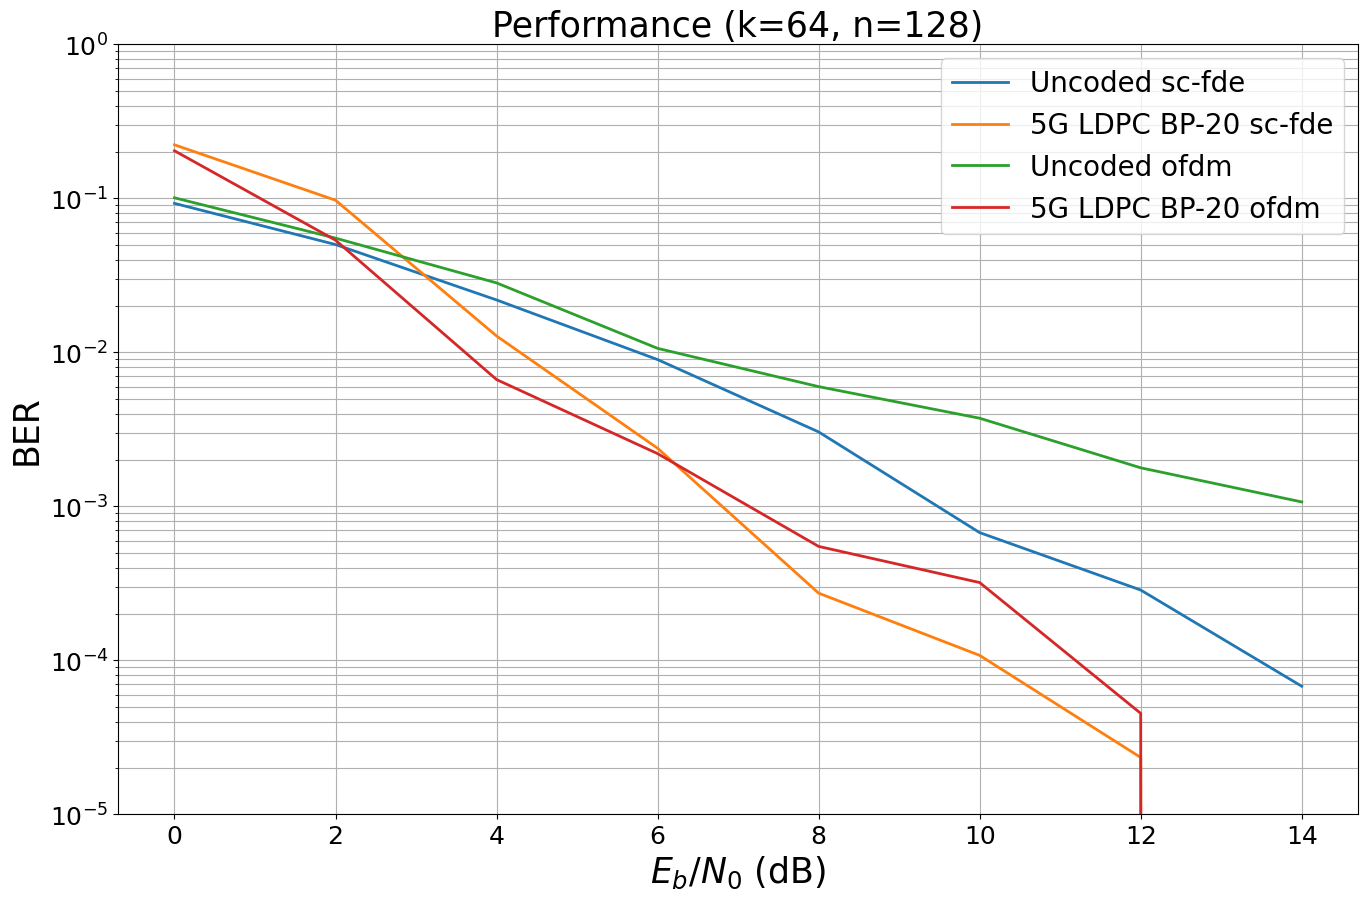

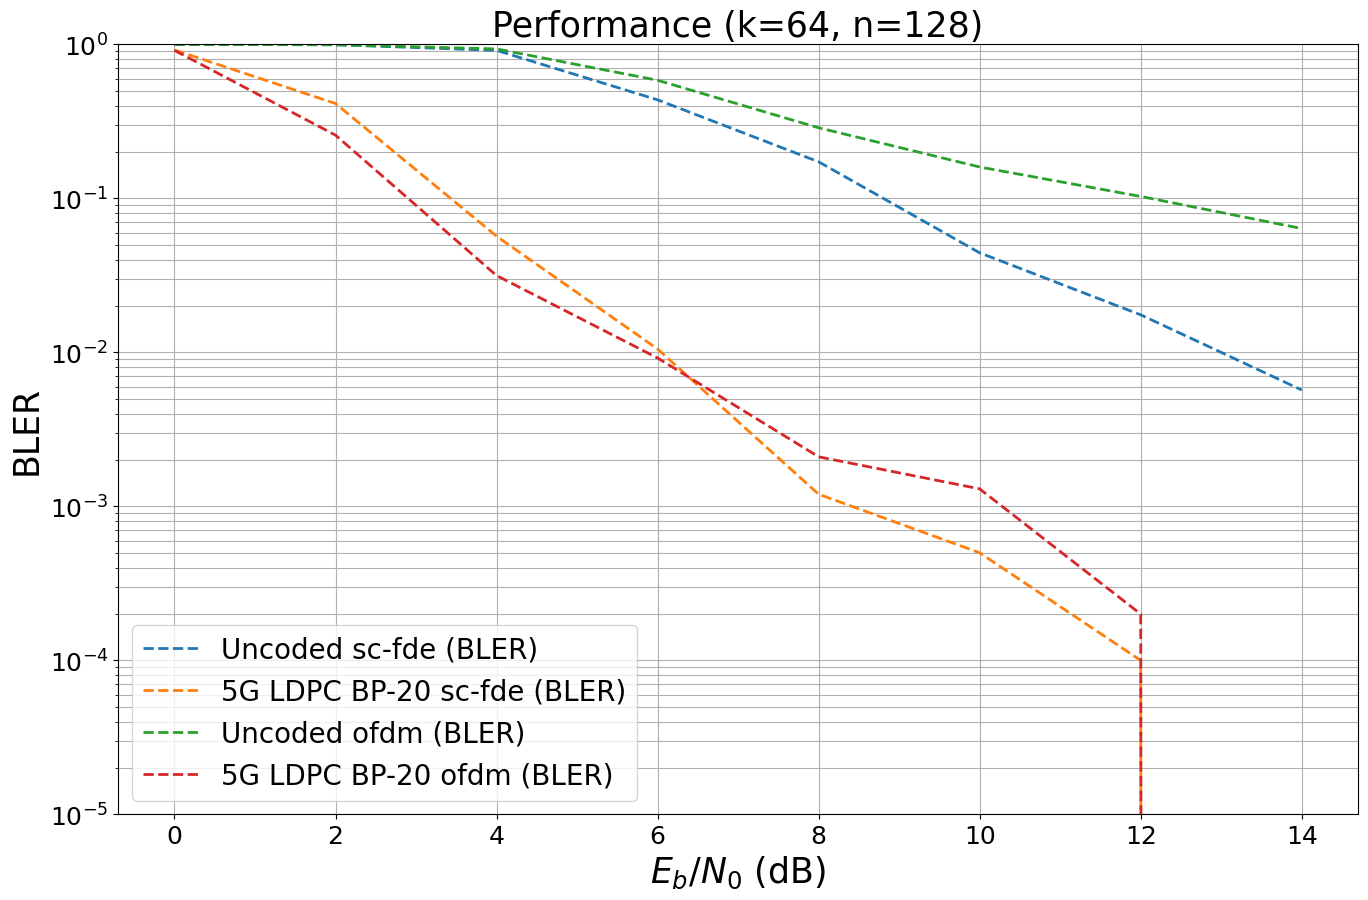

In [5]:
# code parameters
n = 128 # desired codeword length
k = 64  # number of information bits per codeword
num_bits_per_symbol = 2 #
channel_mode = 'tdl' # tdl awgn
modes = ["sc-fde", "ofdm"]

# Create list of encoder/decoder pairs to be analyzed.
codes_under_test = []
codes_under_test.append([None, None, "Uncoded"])
enc = LDPC5GEncoder(k=k, n=n)
dec = LDPC5GDecoder(enc, num_iter=50)
name = "5G LDPC BP-20"
codes_under_test.append([enc, dec, name])
ebno_db = np.arange(0, 16, 2) # sim SNR range
ber_plot128 = PlotBER(f"Performance (k={k}, n={n})")

# run ber simulations for each code we have added to the list


for mode in modes:

  print("\n\nMode: ", mode)
  for code in codes_under_test:
      print("\nRunning: " + code[2])

      # For uncoded, set n=k
      if code[0] is None and code[1] is None:
          model = System_Model(k=n,
                               n=n,  # n=k for uncoded
                               num_bits_per_symbol=num_bits_per_symbol,
                               encoder=None,
                               decoder=None,
                               sim_esno=False,
                               channel=channel_mode,
                               mode=mode,)

      else:
          model = System_Model(k=k,
                               sim_esno=False,
                               n=n,
                               num_bits_per_symbol=num_bits_per_symbol,
                               encoder=code[0],
                               decoder=code[1],
                               channel=channel_mode,
                               mode=mode)

      ber_plot128.simulate(model,
                           ebno_dbs=ebno_db,
                           legend=f"{code[2]} {mode}",
                           max_mc_iter=100,
                           num_target_block_errors=100,
                           batch_size=100,
                           soft_estimates=False,
                           target_ber=1e-4,
                           early_stop=True,
                           show_fig=False,
                           add_bler=True,
                           forward_keyboard_interrupt=True);

ber_plot128(ylim=(1e-5, 1),
              show_bler=False)  # we set the ylim to 1e-5 as otherwise more extensive simulations would be required for accurate curves.
plt.show()
ber_plot128(ylim=(1e-5, 1), show_bler=True,
              show_ber=False)  # we set the ylim to 1e-5 as otherwise more extensive simulations would be required for accurate curves.
plt.show()
